<a href="https://colab.research.google.com/github/24Zen/Handwritten_Character/blob/main/Handwritten_Character_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ติดตั้งไลบรารีที่จำเป็น
!pip install tensorflow
!pip install emnist
!pip install ipywidgets
!pip install ipycanvas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 2.4 MB/s eta 0:00:00


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.4DHSZK_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.4DHSZK_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.


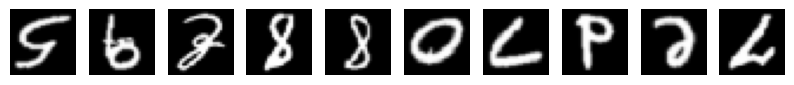

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# โหลด EMNIST แบบ split 'byclass' (รวมตัวพิมพ์เล็ก-ใหญ่และเลข)
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# ฟังก์ชันแปลงภาพให้เป็น float และ normalize
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.rot90(image, k=1)  # หมุนให้ถูกทิศ
    image = tf.image.flip_left_right(image)
    return image, label

# เตรียมชุดข้อมูล
ds_train = ds_train.map(preprocess).batch(64).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(64).prefetch(tf.data.AUTOTUNE)

# ดูตัวอย่างภาพ
for images, labels in ds_train.take(1):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(tf.squeeze(images[i]), cmap='gray')
        plt.axis('off')
    plt.show()
    break


In [ ]:
# จำนวนคลาสใน EMNIST 'byclass'
NUM_CLASSES = ds_info.features['label'].num_classes

# สร้างโมเดล CNN ง่ายๆ
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# คอมไพล์โมเดล
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# แสดง summary ของโมเดล
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 62)             │         7,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,742 (905.24 KB)

 Trainable params: 231,742 (905.24 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 5  # ถ้ามี GPU ปรับมากขึ้นได้ เช่น 10+

history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=EPOCHS
)


Epoch 1/5
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 690s 63ms/step - accuracy: 0.7852 - loss: 0.6913 - val_accuracy: 0.8521 - val_loss: 0.4059
Epoch 2/5
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 674s 62ms/step - accuracy: 0.8573 - loss: 0.3920 - val_accuracy: 0.8568 - val_loss: 0.3860
Epoch 3/5
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 687s 62ms/step - accuracy: 0.8655 - loss: 0.3631 - val_accuracy: 0.8588 - val_loss: 0.3822
Epoch 4/5
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 678s 62ms/step - accuracy: 0.8702 - loss: 0.3460 - val_accuracy: 0.8613 - val_loss: 0.3783
Epoch 5/5
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 671s 61ms/step - accuracy: 0.8739 - loss: 0.3333 - val_accuracy: 0.8621 - val_loss: 0.3804


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving S__4374563.jpg to S__4374563.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3650 (\N{THAI CHARACTER SARA O}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3617 (\N{THAI CHARACTER MO MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3604 (\N{THAI CHARACTER DO DEK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3621 (\N{THAI CHARACTER LO LING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


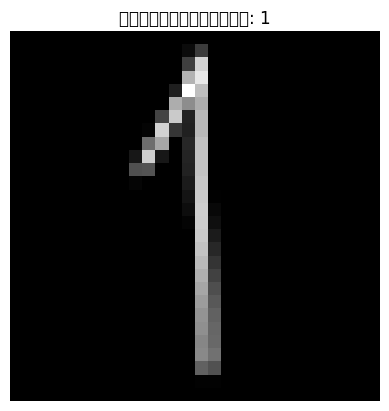

In [ ]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

# ใช้ชื่อไฟล์ที่อัปโหลด
filename = next(iter(uploaded))

# เตรียมภาพ
img = Image.open(filename).convert('L')
img = ImageOps.invert(img)
img = img.resize((28, 28))
img_np = np.array(img) / 255.0
img_np = np.expand_dims(img_np, axis=-1)
img_np = np.expand_dims(img_np, axis=0)

# ทำนาย
prediction = model.predict(img_np)
predicted_label = np.argmax(prediction)

# แสดงผล
plt.imshow(img, cmap='gray')
plt.title(f"โมเดลทำนายว่า: {predicted_label}")
plt.axis('off')
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving S__4374564.jpg to S__4374564.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


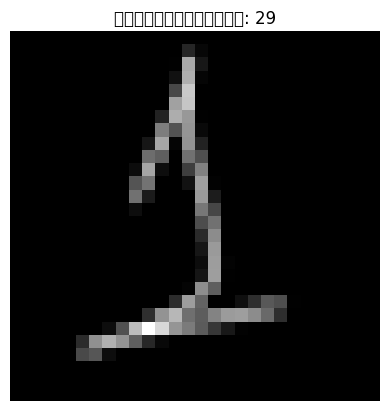

In [ ]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

# ใช้ชื่อไฟล์ที่อัปโหลด
filename = next(iter(uploaded))

# เตรียมภาพ
img = Image.open(filename).convert('L')
img = ImageOps.invert(img)
img = img.resize((28, 28))
img_np = np.array(img) / 255.0
img_np = np.expand_dims(img_np, axis=-1)
img_np = np.expand_dims(img_np, axis=0)

# ทำนาย
prediction = model.predict(img_np)
predicted_label = np.argmax(prediction)

# แสดงผล
plt.imshow(img, cmap='gray')
plt.title(f"โมเดลทำนายว่า: {predicted_label}")
plt.axis('off')
plt.show()
